# Fluorescence Spectrum error propagation validation
Propagating the uncertainties of the quantum efficiencies and the
wavelength calibration to the final spectrum is not trivial. In the
`spectrum` method of the `agepy.spec.photons.Spectrum` class the
error propagation can be performed using either Monte Carlo error
propagation or by numerically computing a Jacobi matrix.
In order to test both approaches a study is performed using a "true"
spectrum and "true" quantum efficiencies and calibration parameters
each with "true" uncertainties based on which samples are drawn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from agepy.spec.photons import Spectrum
from agepy import ageplot
ageplot.use("age")

In [2]:
# Define a binning for the spectrum
xedges = np.histogram([], bins=256, range=(128.67, 128.67 + 38.94))[1]
# Define a region of interest
roi = ((0.2, 0.8), (0, 1))
# Define detector positions for the efficiency values
qeff_x = np.linspace(0.1, 0.9, 30)
# Create a random number generator
rng = np.random.default_rng()

The following function simulates one sample of the "true" spectrum with
"realistic" conditions.
The "true" spectrum has 10000 counts, but each
samples number of counts `n` is based on a random number drawn from a
Poisson distribution.
The "true" spectrum is one Gaussian at detector position 0.5 with a
standard deviation of 0.1 and for each sample `n` values are randomly
generated from this Gaussian.
The "true" quantum efficiencies are 0.9 everywhere on the detector, but
only known at 30 positions on the detector with the "true"
measurement uncertainties of 0.1 at each point. For the sample the
efficiencies are randomly generated from a normal distribution.
The same procedure is applied to the wavelength calibration parameters.
For this sample the spectrum and the uncertainties are calculated.

In [3]:
def simulate_spectrum(err_prop):
    # Simulate the number of photons
    n = rng.poisson(lam=10000)

    # Simulate the photon hits
    xdata = rng.normal(0.5, 0.1, n)
    ydata = np.ones(n) * 0.5
    data = np.stack([xdata, ydata], axis=1)

    # Create the spectrum object
    spectrum = Spectrum(data)

    # Simulate detector efficiencies
    qeff_val = rng.normal(0.9, 0.1, 30)
    qeff_err = np.ones(30) * 0.1
    qeff = (qeff_val, qeff_err, qeff_x)

    # Simulate calibration
    a0 = rng.normal(128.67, 0.07)
    a1 = rng.normal(38.94, 0.01)
    calib = ((a0, 0.07), (a1, 0.01))

    # Simulate the spectrum
    return spectrum.spectrum(xedges, roi=roi, qeff=qeff, calib=calib, err_prop=err_prop)

First, a Monte Carlo simulation is performed in order to get the correct
uncertainties on the bin counts. This is done by calculating the
spectrum for 100000 samples without caring about returned uncertainties
and instead getting the "true" uncertainties by calculating the
standard deviation of the 100000 spectra.

In [4]:
true_spec = np.zeros((100000, len(xedges) - 1), dtype=np.float64)

for i in range(100000):
    true_spec[i] = simulate_spectrum("none")[0]

# Calculate the "true" uncertainties
true_err = np.std(true_spec, axis=0)
true_spec = np.mean(true_spec, axis=0)

The error propagation is then performed for single samples 100 times and
the returned uncertainties are averaged in order to get a more
significant result.

In [5]:
jacobi_err = np.zeros((100, len(xedges) - 1), dtype=np.float64)

for i in range(100):
    jacobi_err[i] = simulate_spectrum("jacobi")[1]

# Calculate the mean of the Jacobi uncertainties
jacobi_err_err = np.std(jacobi_err, axis=0)
jacobi_err = np.mean(jacobi_err, axis=0)

In [6]:
mc_err = np.zeros((100, len(xedges) - 1), dtype=np.float64)

for i in range(100):
    mc_err[i] = simulate_spectrum("montecarlo")[1]

# Calculate the mean of the Monte Carlo uncertainties
mc_err_err = np.std(mc_err, axis=0)
mc_err = np.mean(mc_err, axis=0)

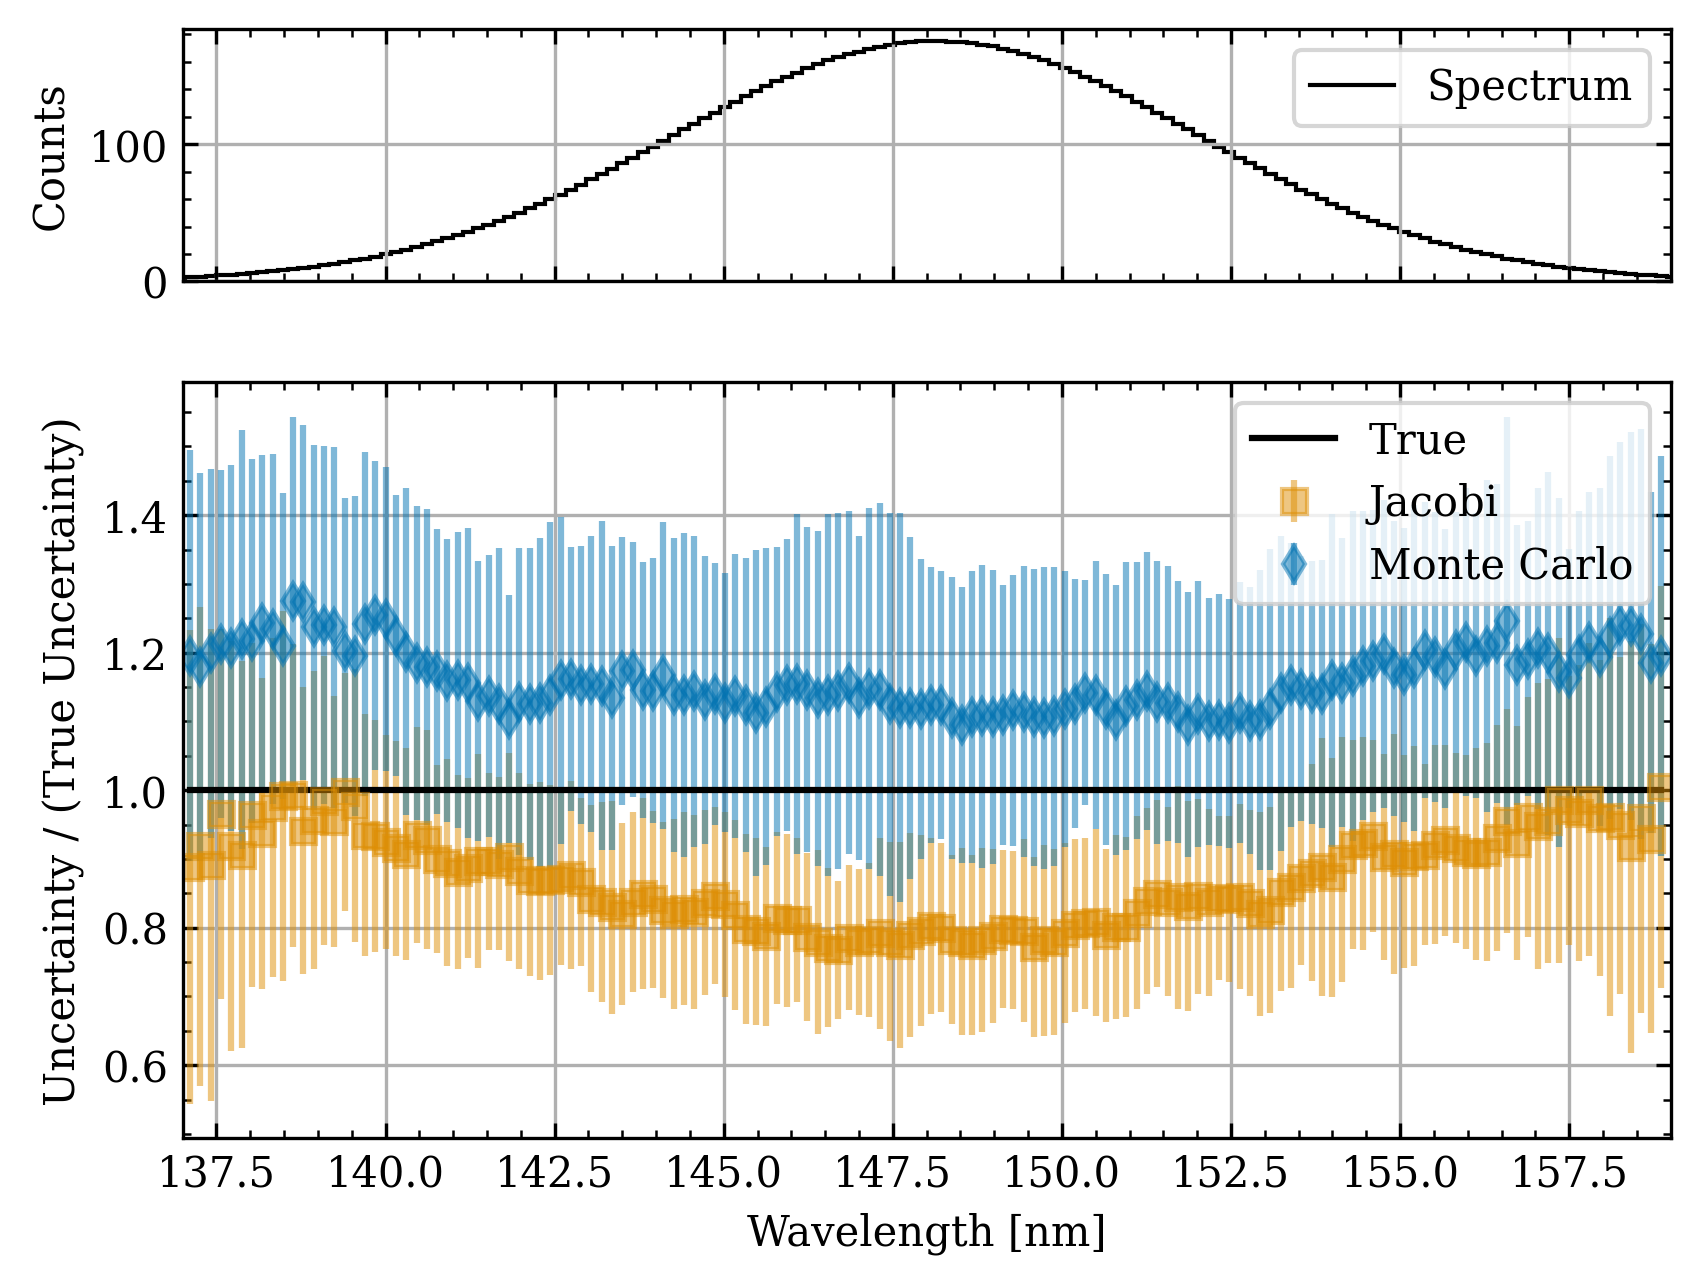

In [13]:
fig, ax = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])
# Select the uncertainties in a sensible region
xvalues = (xedges[1:] + xedges[:-1]) * 0.5
inds = np.argwhere(np.logical_and(xvalues >= 137, xvalues <= 159)).flatten()
xvalues = xvalues[inds]
true = true_err[inds]
jacobi_ = jacobi_err[inds]
jacobi_err_ = jacobi_err_err[inds]
mc_ = mc_err[inds]
mc_err_ = mc_err_err[inds]
# Plot the uncertainties relative to the true uncertainties
ax[0].stairs(true_spec, xedges, color="k", label="Spectrum")
ax[0].legend()
ax[0].set_ylabel("Counts")
ax[1].errorbar(xvalues, jacobi_ / true, yerr=jacobi_err_ / true, fmt="s", color=ageplot.colors[1], alpha=0.5, label="Jacobi")
ax[1].errorbar(xvalues, mc_ / true, yerr=mc_err_ / true, fmt="d", color=ageplot.colors[0], alpha=0.5, label="Monte Carlo")
ax[1].plot(xvalues, np.ones_like(true), color="k", label="True")
ax[1].set_xlim(137, 159)
ax[1].set_xlabel("Wavelength [nm]")
ax[1].set_ylabel("Uncertainty / (True Uncertainty)")
ax[1].legend()
plt.show()

The Jacobi method underestimates the "true" uncertainties, while the
Monte Carlo error propagation slightly overestimates them. The Jacobi
method is however significantly faster and requires less memory.